# Bias Maps: AGCD and CORDEX Simulations - Includes 2 Metrics on the map (NRMSE and Pattern Cor)

In [1]:
# Import modules
%matplotlib inline
%run /g/data/w40/ri9247/code/master_functions_bmf.ipynb
import matplotlib as mpl
import fnmatch
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import cartopy as cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

## Define Spatiotemporal Boundaries

In [2]:
# Define region of interest (lat and lon boundaries for all of Australia)
lat_slice = slice(-44.5,-10)
lon_slice = slice(112,156.25)
time_slice = slice("1976-01-01", "2005-12-30")

# Define temporal scale for SPI variable (1 for 3-months, 2 for 6-months, 3 for 12-months); use "None" if not using the SPI variable
iscale = None

# Define season as a list of month numbers. If not wanting a seasonal breakdown, use None.
# Suggestions: Wet 6-month: [10,11,12,1,2,3]; Dry 6-month: [4,5,6,7,8,9]; Wet 3-month: [12,1,2]; Dry 3-month: [6,7,8]
season = None #[12,1,2]
season_name = 'Annual' #'3-Month Wet: DJF' #'3-Month Dry: JJA' 

# Paths to mask datasets
mask_ds = xr.open_dataset('/g/data/w40/ri9247/CORDEX-Australasia/data/obs/AUS-44i_grid/no_indices/mask/AUS-44i_combined_quality_mask_no_oceans.nc')

# Extract masks over Australia
mask = mask_ds.station_mask.sel(lat=lat_slice, lon=lon_slice)

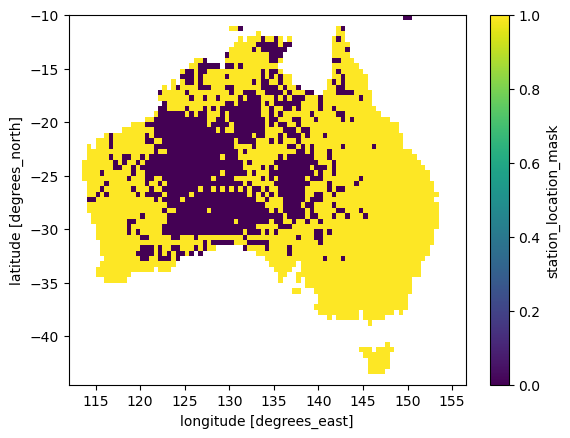

In [3]:
mask.plot()

## Define Benchmarking Thresholds for Metrics: NRMSE and Spatial Correlation

In [3]:
mape_threshold = 0.75
sc_threshold = 0.75

## Define Keywords for Data

Keywords needed are bracketed {}. RCM da are set-up following: <br><br>
**Climpact Indices:** <br>
parent_directory/CORDEX-Australasia/data/{rcm-or-gcm}/{grid_type}/climpact/{historical-or-future}/{indice-keyword}/{yr-or-mon}/dataset_file.nc <br>
<br>
**Keyword Options:** <br>
model_type: 'rcm', 'gcm' <br>
GCM grid_type: 'coarsest_gcm_grid', 'native_grid' <br>
RCM grid_type: 'AUS-44i_grid', 'coarsest_gcm_grid', 'driving-GCM-grid', 'native_grid', 'one_degree_grid' <br>
time_period: 'historical', 'future' <br>
variable: See list of Climpact Indices at: https://climpact-sci.org/indices; must be all-lowercase <br>
temporal_resolution: 'yr', 'mon'

### Using Climpact Indices

In [4]:
# Define keywords to be used with f-strings to build the path to datasets
model_type = 'rcm'
grid_type = 'AUS-44i_grid'
time_period = 'historical'
variable = 'prcptot'
temporal_resolution = 'yr'
obs_temporal_resolution = 'ANN'

# Define paths to data
master_path = '/g/data/w40/ri9247/CORDEX-Australasia/data/'

model_data_path = master_path + f"{model_type}/{grid_type}/climpact/{time_period}/{variable}/{temporal_resolution}/"
agcd_data_path = master_path + f"obs/{grid_type}/climpact/{variable}/{variable}_{obs_temporal_resolution}_agcd_historical_v1_1950-2020.nc"
#agcd_data_path = '/scratch/wq02/ri9247/tmp/agcd_preproc/0.5_deg/climpact/prcptot_ANN_agcd_historical_r050_1900-2022.nc'

## Get Pandas Dataframe with complete list of model dataset file paths

In [5]:
# Get all model paths in full ensemble (this will be stored in a Pandas DataFrame)
model_paths = get_model_files(model_data_path)

# Expand the column with to see the full paths stored in the Pandas Dataframe
pd.set_option('display.max_colwidth', None)

# Check that correct file paths are selected
model_paths

,rcm,driving_gcm,dataset_path
0,CCAM-2008,NorESM1-M,/g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/yr/prcptot_ANN_AUS-44i_NCC-NorESM1-M_historical_r1i1p1_CSIRO-CCAM-2008_v1_day_19600101-20051231.nc
1,CCAM-1704,MIROC5,/g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/yr/prcptot_ANN_AUS-44i_MIROC-MIROC5_historical_r1i1p1_CSIRO-CCAM-1704_v1_day_19600101-20051231.nc
2,CCAM-2008,GFDL-ESM2M,/g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/yr/prcptot_ANN_AUS-44i_NOAA-GFDL-GFDL-ESM2M_historical_r1i1p1_CSIRO-CCAM-2008_v1_day_19600101-20051231.nc
3,CCAM-2008,CanESM2,/g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/yr/prcptot_ANN_AUS-44i_CCCma-CanESM2_historical_r1i1p1_CSIRO-CCAM-2008_v1_day_19600101-20051231.nc
4,CCAM-1704,NorESM1-M,/g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/yr/prcptot_ANN_AUS-44i_NCC-NorESM1-M_historical_r1i1p1_CSIRO-CCAM-1704_v1_day_19600101-20051231.nc
5,RegCM4-7,HadGEM2-ES,/g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/yr/prcptot_ANN_AUS-44i_MOHC-HadGEM2-ES_historical_r1i1p1_ICTP-RegCM4-7_v0_day_19700101-20051230.nc
6,REMO2015,NorESM1-M,/g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/yr/prcptot_ANN_AUS-44i_NCC-NorESM1-M_historical_r1i1p1_GERICS-REMO2015_v1_day_19700101-20051231.nc
7,WRF360J,CanESM2,/g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/yr/prcptot_ANN_AUS-44i_CCCma-CanESM2_historical_r1i1p1_UNSW-WRF360J_v1_day_19510101-20051231.nc
8,WRF360K,CanESM2,/g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/yr/prcptot_ANN_AUS-44i_CCCma-CanESM2_historical_r1i1p1_UNSW-WRF360K_v1_day_19510101-20051231.nc
9,CCAM-1704,GFDL-ESM2M,/g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/yr/prcptot_ANN_AUS-44i_NOAA-GFDL-GFDL-ESM2M_historical_r1i1p1_CSIRO-CCAM-1704_v1_day_19600101-20051231.nc


## Get Individual Model Bias

In [6]:
# Note data_type is model so units are properly converted if daily or monthly mean data
# Keyword "model" will convert precip data to mm/day from kg/m^2/s; any other keyword will keep native units
data_type = 'model_climpact'

# Intialize an empty dictionary to store model climatologies as DataArrays
bias_model_dict = {}

# Loop through RCM simulations and calculate the model bias; store in a dictionary
for i, row in model_paths.iterrows():
    bias_xr = get_bias(row[2], agcd_data_path, variable, time_slice, lat_slice, lon_slice, data_type, season, iscale, mask)
    bias_model_dict[f'{row[1]}   {row[0]}'] = bias_xr

# Option to print dictionary keys (model names)
print(bias_model_dict.keys())

dict_keys(['NorESM1-M   CCAM-2008', 'MIROC5   CCAM-1704', 'GFDL-ESM2M   CCAM-2008', 'CanESM2   CCAM-2008', 'NorESM1-M   CCAM-1704', 'HadGEM2-ES   RegCM4-7', 'NorESM1-M   REMO2015', 'CanESM2   WRF360J', 'CanESM2   WRF360K', 'GFDL-ESM2M   CCAM-1704', 'MIROC5   CCAM-2008', 'ACCESS1-0   WRF360K', 'MPI-ESM-LR   CCLM5-0-15', 'CNRM-CM5   CCAM-1704', 'NorESM1-M   CCLM5-0-15', 'HadGEM2-CC   CCAM-1704', 'NorESM1-M   RegCM4-7', 'HadGEM2-ES   CCLM5-0-15', 'MPI-ESM-LR   REMO2015', 'HadGEM2-ES   REMO2015', 'MPI-ESM-MR   RegCM4-7', 'ACCESS1-0   WRF360J', 'ACCESS1-0   CCAM-2008', 'ACCESS1-0   CCAM-1704'])


## Calculate Weighted Spatial Average (of bias) and Store in Pandas Dataframe for sorting plots

### Models

In [7]:
# Set up empty data frame to store values
model_weighted_avg_master_df = pd.DataFrame(columns=["weighted_average", "dataset_name"])

# Loop through Dictionary of climatologies and calculate spatial weighted average
for model_name in bias_model_dict.keys():
    model_weighted_avg = get_weighted_spatial_average_from_data(bias_model_dict[model_name]).round(2)
        
    # Convert the resulting xarray to a pandas df
    model_weighted_avg_df = pd.DataFrame({'weighted_average': model_weighted_avg.item(0), 'dataset_name': f'{model_name}'}, index=[0])
    
    # Append the master time series 
    model_weighted_avg_master_df = pd.concat([model_weighted_avg_master_df, model_weighted_avg_df], ignore_index=True)

# Sort weighted spatial average wettest to driest
model_weighted_avg_master_df = model_weighted_avg_master_df.sort_values("weighted_average", ascending=False)

# Option to print DataFrame
#print(model_weighted_avg_master_df)

## Get MAPE and uncentered Spatial Correlation and store in Pandas Dataframe

In [10]:
rcm_master_metrics_df = pd.DataFrame(columns=[f"{variable}_mape", f"{variable}_spatial_cor", "GCM_RCM_pair"])

# Define if you want centered (True) or uncentered (False) correlation 
centered = True

# 'model' will include appropriate unit conversion
datatype = 'model_climpact'

# Loop through RCMs and calculate the spatial correlation against the obs data
for i, row in model_paths.iterrows(): 
    
    # Calculate correlation coefficient between each model and observation data
    spatial_cor_xr = get_spatial_correlation(row[2], agcd_data_path, variable, time_slice, lat_slice, lon_slice, season, iscale, mask, centered)
    #nrmse_xr = get_nrmse_mean(row[2], agcd_data_path, variable, time_slice, lat_slice, lon_slice, datatype, season, iscale, mask)
    mape_xr = get_mape(row[2], agcd_data_path, variable, time_slice, lat_slice, lon_slice, datatype, season, iscale, mask)
    
    # Convert the resulting xarray to a pandas df
    metrics_df = pd.DataFrame({f"{variable}_mape": mape_xr.item(0), f"{variable}_spatial_cor": spatial_cor_xr.item(0),'GCM_RCM_pair': f"{row[1]}   {row[0]}"}, index=[0])
        
    # Append the master time series 
    rcm_master_metrics_df = pd.concat([rcm_master_metrics_df, metrics_df], ignore_index=True)

rcm_master_metrics_df = rcm_master_metrics_df.reset_index(drop = True)
print(rcm_master_metrics_df)

    prcptot_mape  prcptot_spatial_cor             GCM_RCM_pair
0           0.26                 0.91    NorESM1-M   CCAM-2008
1           0.38                 0.88       MIROC5   CCAM-1704
2           0.31                 0.92   GFDL-ESM2M   CCAM-2008
3           0.75                 0.84      CanESM2   CCAM-2008
4           0.33                 0.89    NorESM1-M   CCAM-1704
5           1.13                 0.90    HadGEM2-ES   RegCM4-7
6           0.25                 0.92     NorESM1-M   REMO2015
7           0.39                 0.87        CanESM2   WRF360J
8           0.26                 0.67        CanESM2   WRF360K
9           0.30                 0.90   GFDL-ESM2M   CCAM-1704
10          0.49                 0.88       MIROC5   CCAM-2008
11          0.50                 0.79      ACCESS1-0   WRF360K
12          0.29                 0.85  MPI-ESM-LR   CCLM5-0-15
13          0.33                 0.89     CNRM-CM5   CCAM-1704
14          0.40                 0.83   NorESM1-M   CCL

## Set Up Panel Plot Sorted by Spatial Area Average

### Set up mapping constants

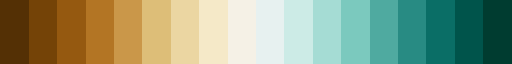

In [11]:
# Define map constants and specifications
extent = [112, 156.25, -44.5, -10]
proj = ccrs.PlateCarree()

# Axes indices where I want lat and/or lon tickmarks on the map
lat_label = [0,4,8,12,16]
lon_label = [21,22,23]
both_label = [20]

# Lat/Lon values to show for axis labels
lat_ticks = [-10,-20,-30,-40]
lon_ticks = [115,125,135,145,155]

# Define colormap
cmap = plt.get_cmap('BrBG',18)
#cmap = cmap.reversed()
mmin = -300
mmax = 300

cmap

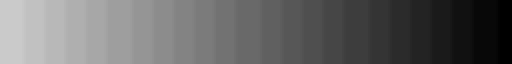

In [12]:
# Define color for quality mask
cmap_mask_i = plt.get_cmap('gray',30)
cmap_mask_i = cmap_mask_i.reversed()
cmap_mask = truncate_colormap(cmap_mask_i, 0.2, 0.99, 100)

cmap_mask

### Create Sorted Panel Plot - Portrait (for Paper)

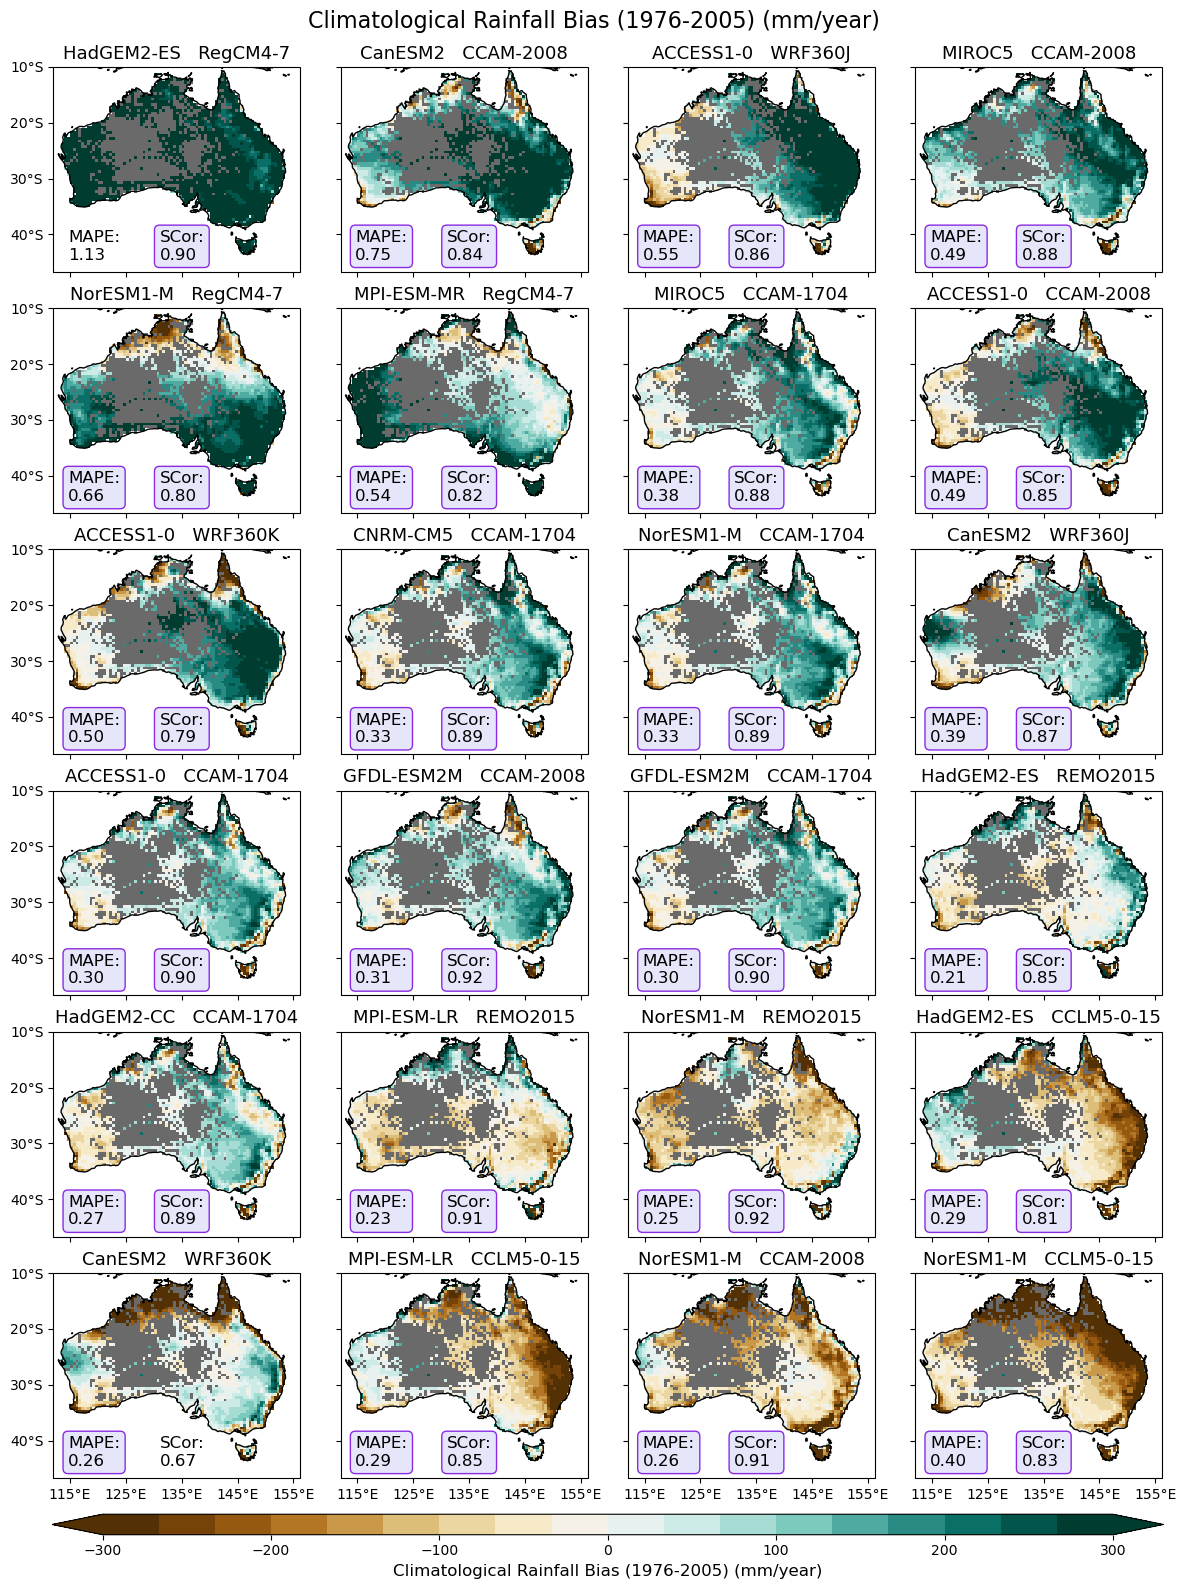

In [13]:
# Define figure size
fig = plt.figure(figsize=(12,16))
fig.suptitle(f"Climatological Rainfall Bias (1976-2005) (mm/year)", fontsize=16, y=0.99)

# Setup axes for all subplots
gs = gridspec.GridSpec(7,4,width_ratios=[1,1,1,1], height_ratios=[1,1,1,1,1,1,0.1])

row_max = 6
col_max = 3
row = 0
col = 0

axs = {}

# Set up Axes labels (this loops through the sorted Pandas DF to assign axes positions based on wetness)
# For Models
for i, df_row_mod in model_weighted_avg_master_df.iterrows():
    axs[f'{df_row_mod[1]}'] = fig.add_subplot(gs[row,col], projection=proj)
    
    if col == col_max:
        row = row + 1
        col = 0 
    else:
        col = col + 1
        

for name, ax in axs.items():
    ax.set_title(name, fontsize=13)
    
# Plot climtologies and spatial weighted mean 
# Define empty dictionary of plots
plots = {}

# Plot climatology maps and add spatial weighted average for model data   
for model_name in bias_model_dict.keys():
    
    # Define NRMSE and SCor for each model
    mape_score = rcm_master_metrics_df[rcm_master_metrics_df['GCM_RCM_pair'] == f'{model_name}'].iloc[0,0]
    sc_score = rcm_master_metrics_df[rcm_master_metrics_df['GCM_RCM_pair'] == f'{model_name}'].iloc[0,1]
    
    # Plot Data and add grey mask 
    plots[model_name] = bias_model_dict[model_name].plot(ax=axs[model_name], add_labels=False, add_colorbar=False, vmin=mmin, vmax=mmax, cmap=cmap)
    (mask.where(mask==0.)).plot(ax=axs[model_name], add_labels=False, add_colorbar=False, cmap=cmap_mask)
    #axs[model_name].text(0.06, 0.06, 'NRMSE:\n%.2f' % (nrmse_score), fontsize=12.0, transform=axs[model_name].transAxes)
    #axs[model_name].text(0.43, 0.06,'PC:\n%.2f' % (pc_score), transform=axs[model_name].transAxes, fontsize=12.0)
    
    # Check if models fail/not fail benchmarking thresholds; draw square around passing values
    # Check NRMSE
    if mape_score <= mape_threshold:
        axs[model_name].text(0.06, 0.06, 'MAPE:\n%.2f' % (mape_score), fontsize=12.0, transform=axs[model_name].transAxes,
                            bbox=dict(facecolor='lavender', edgecolor='blueviolet',boxstyle='round'))
            
    elif mape_score > mape_threshold:
        axs[model_name].text(0.06, 0.06, 'MAPE:\n%.2f' % (mape_score), fontsize=12.0, transform=axs[model_name].transAxes)
    
    # Check Pattern Correlation
    if sc_score >= sc_threshold:
        axs[model_name].text(0.43, 0.06,'SCor:\n%.2f' % (sc_score), fontsize=12.0, transform=axs[model_name].transAxes,
                            bbox=dict(facecolor='lavender', edgecolor='blueviolet',boxstyle='round'))
            
    elif sc_score <= sc_threshold:
        axs[model_name].text(0.43, 0.06,'SCor:\n%.2f' % (sc_score), fontsize=12.0, transform=axs[model_name].transAxes)  
          
# Add coastlines and set map extent
for ax in axs.values():
    ax.coastlines()
    ax.set_extent(extent)
    #ax.add_feature(cartopy.feature.OCEAN)
    

# Add lat and long values on first column and bottom row; add empty tick marks to the rest of the plots    
for i, ax in enumerate(fig.axes):
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    if i in lat_label:
        ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
    elif i in lon_label:
        ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
    elif i in both_label:
        ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
        ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
    else:
        continue


# Plot colorbars
cbar_gs = gridspec.GridSpecFromSubplotSpec(1,1, subplot_spec=gs[6,:], hspace=0.5)
cbar_ax = fig.add_subplot(cbar_gs[0,0])
plt.colorbar(plots['CanESM2   WRF360J'], cbar_ax, orientation='horizontal', extend='both')
cbar_ax.set_xlabel(f"Climatological Rainfall Bias (1976-2005) (mm/year)",fontsize=12.0)

# Plot with tight layout
plt.tight_layout()

## Extra code for landscape display of plots (better for PPT)

In [ ]:
# Update plot numbers that get lat and lon labels
lat_label = [0,6,12]
lon_label = [19,20,21,22,23]
both_label = [18]


# Define figure size
fig = plt.figure(figsize=(16,11))
fig.suptitle(f"Climatological Rainfall Bias (1976-2005) (mm/year)", fontsize=16, y=0.99)

# Setup axes for all subplots
gs = gridspec.GridSpec(5,6,width_ratios=[1,1,1,1,1,1], height_ratios=[1,1,1,1,0.1])

row_max = 3
col_max = 5
row = 0
col = 0

axs = {}

# Set up Axes labels (this loops through the sorted Pandas DF to assign axes positions based on wetness)
# For Models
for i, df_row_mod in model_weighted_avg_master_df.iterrows():
    axs[f'{df_row_mod[1]}'] = fig.add_subplot(gs[row,col], projection=proj)
    
    if col == col_max:
        row = row + 1
        col = 0 
    else:
        col = col + 1
        

for name, ax in axs.items():
    ax.set_title(name, fontsize=12)
    
# Plot climtologies and spatial weighted mean 
# Define empty dictionary of plots
plots = {}


# Plot climatology maps and add spatial weighted average for model data      
for model_name in bias_model_dict.keys():
    
    # Define NRMSE and PC for each model
    mape_score = rcm_master_metrics_df[rcm_master_metrics_df['GCM_RCM_pair'] == f'{model_name}'].iloc[0,0]
    sc_score = rcm_master_metrics_df[rcm_master_metrics_df['GCM_RCM_pair'] == f'{model_name}'].iloc[0,1]
    
    # Plot Data and add grey mask 
    plots[model_name] = bias_model_dict[model_name].plot(ax=axs[model_name], add_labels=False, add_colorbar=False, vmin=mmin, vmax=mmax, cmap=cmap)
    (mask.where(mask==0.)).plot(ax=axs[model_name], add_labels=False, add_colorbar=False, cmap='gray')
    #axs[model_name].text(0.06, 0.06, 'NRMSE:\n%.2f' % (nrmse_score), fontsize=12.0, transform=axs[model_name].transAxes)
    #axs[model_name].text(0.43, 0.06,'PC:\n%.2f' % (pc_score), transform=axs[model_name].transAxes, fontsize=12.0)
    
    # Check if models fail/not fail benchmarking thresholds; draw square around passing values
    # Check NRMSE
    if mape_score <= mape_threshold:
        axs[model_name].text(0.06, 0.06, 'MAPE:\n%.2f' % (mape_score), fontsize=12.0, transform=axs[model_name].transAxes,
                            bbox=dict(facecolor='lavender', edgecolor='blueviolet', boxstyle='round'))
            
    elif mape_score > mape_threshold:
        axs[model_name].text(0.06, 0.06, 'MAPE:\n%.2f' % (mape_score), fontsize=12.0, transform=axs[model_name].transAxes)
    
    # Check Pattern Correlation
    if sc_score >= sc_threshold:
        axs[model_name].text(0.43, 0.06,'SC:\n%.2f' % (sc_score), fontsize=12.0, transform=axs[model_name].transAxes,
                            bbox=dict(facecolor='lavender', edgecolor='blueviolet',boxstyle='round'))
            
    elif sc_score <= sc_threshold:
        axs[model_name].text(0.43, 0.06,'SC:\n%.2f' % (sc_score), fontsize=12.0, transform=axs[model_name].transAxes) 
    
# Add coastlines and set map extent
for ax in axs.values():
    ax.coastlines()
    ax.set_extent(extent)

# Add lat and long values on first column and bottom row; add empty tick marks to the rest of the plots    
for i, ax in enumerate(fig.axes):
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    if i in lat_label:
        ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
    elif i in lon_label:
        ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
    elif i in both_label:
        ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
        ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
    else:
        continue


# Plot colorbars
cbar_gs = gridspec.GridSpecFromSubplotSpec(1,1, subplot_spec=gs[4,:], hspace=0.5)
cbar_ax = fig.add_subplot(cbar_gs[0,0])
plt.colorbar(plots['CanESM2   WRF360J'], cbar_ax, orientation='horizontal', extend='both')
cbar_ax.set_xlabel(f"Climatological Rainfall Bias (1976-2005) (mm/day)",fontsize=12.0)

# Plot with tight layout
plt.tight_layout()